In [27]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline


In [28]:
file_paths = ['/kaggle/input/bankdatasetlabeled/bank1.csv',
              '/kaggle/input/bankdatasetlabeled/bank2.csv',
              '/kaggle/input/bankdatasetlabeled/bank3.csv',
              '/kaggle/input/bankdatasetlabeled/bank4.csv']


data_frames = []


for file_path in file_paths:
    df = pd.read_csv(file_path)
    data_frames.append(df)

df = pd.concat(data_frames, ignore_index=True)


In [29]:
print(df.head(10))
len(df)

             ID Cardholders       Label Unnamed: 3             Date  \
0  6.177294e+17       user2   Shopping    Received  7/28/2020 19:29   
1  6.177296e+17       user2   Shopping    Received  7/28/2020 19:33   
2  6.177297e+17       user2   Shopping    Received  7/28/2020 19:35   
3  6.177399e+17       user2        Food   Received  7/28/2020 22:25   
4  6.177399e+17       user2   Shopping    Received  7/28/2020 22:25   
5  6.177399e+17       user2   Shopping    Received  7/28/2020 22:25   
6  6.180759e+17       user2   Utilities   Received   8/1/2020 19:44   
7  6.181526e+17       user2  Transport    Received   8/2/2020 17:03   
8  6.181533e+17       user2  Transport    Received   8/2/2020 17:14   
9  6.181541e+17       user2   Utilities   Received   8/2/2020 17:28   

                                                 SMS  
0  Trx. of AED 451.20 on your card ending **0121 ...  
1  Trx. of AED 21.90 on your card ending **0121 a...  
2  Trx. of AED 133.35 on your card ending **0121 ... 

1383

In [30]:
 
print(df.columns)

Index(['ID', 'Cardholders', 'Label', 'Unnamed: 3', 'Date', 'SMS'], dtype='object')


In [31]:
df=df.drop(['ID', 'Cardholders', 'Unnamed: 3', 'Date'],axis=1)

In [32]:
df.Label.unique()

array(['Shopping ', 'Food', 'Utilities', 'Transport ', 'Health',
       'Shopping', 'Entertainment ', 'shopping ', 'Entertainment',
       'Transport', 'Health ', 'Food ', 'Cash/transfers', 'Income', nan],
      dtype=object)

In [33]:
df.Label.describe()

count     1382
unique      14
top       Food
freq       519
Name: Label, dtype: object

In [34]:
label_mapping = {
    'Shopping ': 'Shopping',
    'shopping ': 'Shopping',
    'Food ': 'Food',
    'Transport ' : 'Transport',
    'Health ' : 'Health',
    'Entertainment ' : 'Entertainment',

}

# Replace the labels in a specific column
df['Label'] = df['Label'].replace(label_mapping)



In [35]:
df.Label.unique()

array(['Shopping', 'Food', 'Utilities', 'Transport', 'Health',
       'Entertainment', 'Cash/transfers', 'Income', nan], dtype=object)

In [36]:
df.isna().sum()

Label    1
SMS      1
dtype: int64

In [37]:
df.dropna(inplace=True)

In [38]:
df.Label.unique()

array(['Shopping', 'Food', 'Utilities', 'Transport', 'Health',
       'Entertainment', 'Cash/transfers', 'Income'], dtype=object)

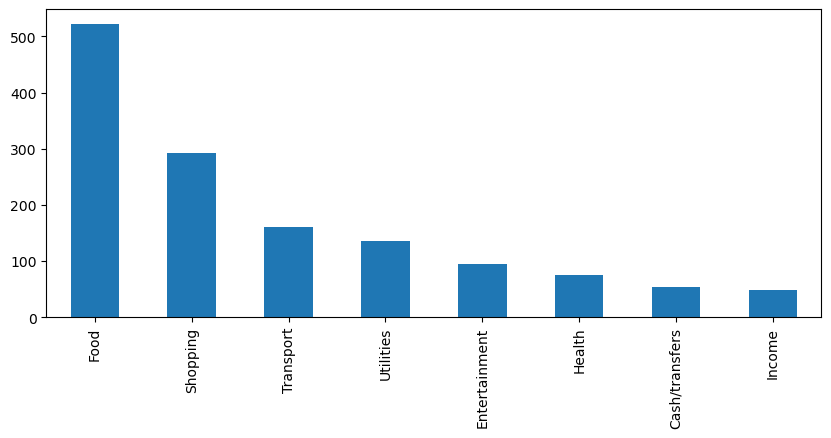

In [39]:
my_tags = ['Shopping', 'Food', 'Utilities', 'Transport', 'Health',
       'Entertainment', 'Cash/transfers', 'Income']
plt.figure(figsize=(10,4))
df.Label.value_counts().plot(kind='bar');

In [40]:
def print_plot(index):
    example = df[df.index == index][['SMS', 'Label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])
print_plot(10)

Trx. of AED 365.00 on your card ending **0121 at MOI TRAFFIC FINES in Abu Dhabi, UNITED ARAB EMI is Approved. Avl card bal is 14580.00.Trx Date: 03/08/20 17:33.
Label: Utilities


In [41]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    date_patterns = [r'\d{2} \d{2} \d{2} \d{4}','date']
    currency_patterns = [
        r'aed \d+(\.\d{1,2})?',  
        r'aed\d+(\.\d{1,2})?',]
    for pattern in currency_patterns:
        text = re.sub(pattern, '', text)
    for pattern in date_patterns:
        text = re.sub(pattern, '', text)
    specific_texts = [
        r'avl card bal \d+trx',  # Matches "avl card bal 1458000trx"
        r'available account balance',  # Matches "available account balance"
        # Add more patterns as needed
    ]
    for pattern in specific_texts:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return text
    
df['SMS'] = df['SMS'].apply(clean_text)
print_plot(10)

/tmp/ipykernel_32/3175085244.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


trx  card ending 0121 moi traffic fines abu dhabi united arab emi approved   
Label: Utilities


In [42]:
print_plot(130)

trx  card ending 0121 green town flowers abu dhabi united arab emi approved   
Label: Shopping


In [43]:
X = df.SMS
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.555956678700361
                precision    recall  f1-score   support

      Shopping       0.83      1.00      0.91         5
          Food       1.00      0.18      0.30        17
     Utilities       0.45      1.00      0.62        98
     Transport       0.00      0.00      0.00        20
        Health       1.00      0.75      0.86         4
 Entertainment       1.00      0.42      0.60        59
Cash/transfers       0.83      0.12      0.22        40
        Income       1.00      0.44      0.61        34

      accuracy                           0.56       277
     macro avg       0.76      0.49      0.51       277
  weighted avg       0.71      0.56      0.50       277



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



sgdpred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(sgdpred, y_test))
print(classification_report(y_test, sgdpred,target_names=my_tags))

accuracy 0.8808664259927798
                precision    recall  f1-score   support

      Shopping       1.00      1.00      1.00         5
          Food       0.88      0.88      0.88        17
     Utilities       0.80      0.99      0.88        98
     Transport       0.94      0.75      0.83        20
        Health       1.00      1.00      1.00         4
 Entertainment       0.96      0.78      0.86        59
Cash/transfers       0.92      0.82      0.87        40
        Income       1.00      0.85      0.92        34

      accuracy                           0.88       277
     macro avg       0.94      0.88      0.91       277
  weighted avg       0.89      0.88      0.88       277



In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Create the CountVectorizer and TfidfTransformer
vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

#  Preprocess the training data using the CountVectorizer and TfidfTransformer
X_train_counts = vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Train the Logistic Regression model
logreg_model = LogisticRegression(n_jobs=1, C=1e5)
logreg_model.fit(X_train_tfidf, y_train)

#  Preprocess the test data using the CountVectorizer and TfidfTransformer
X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#  Make predictions on the test data using the trained model
lrpred = logreg_model.predict(X_test_tfidf)

#  Calculate and print accuracy and classification report
print('Accuracy:', accuracy_score(y_test, lrpred))
print('Classification Report:')
print(classification_report(y_test, lrpred, target_names=my_tags))

print(X_test_tfidf[2])

Accuracy: 0.8844765342960289
Classification Report:
                precision    recall  f1-score   support

      Shopping       0.83      1.00      0.91         5
          Food       0.88      0.82      0.85        17
     Utilities       0.80      0.99      0.89        98
     Transport       1.00      0.85      0.92        20
        Health       1.00      0.75      0.86         4
 Entertainment       0.96      0.76      0.85        59
Cash/transfers       0.92      0.88      0.90        40
        Income       1.00      0.85      0.92        34

      accuracy                           0.88       277
     macro avg       0.92      0.86      0.89       277
  weighted avg       0.90      0.88      0.88       277

  (0, 1491)	0.15215128121729832
  (0, 1489)	0.22893462451202343
  (0, 1464)	0.4817907016894763
  (0, 1116)	0.48524414352171513
  (0, 985)	0.5450645288315412
  (0, 976)	0.12574875206796632
  (0, 878)	0.25149750413593264
  (0, 824)	0.13580999613285294
  (0, 816)	0.1358099961

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle


with open('count_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


with open('tfidf_transformer.pkl', 'wb') as file:
    pickle.dump(tfidf_transformer, file)



In [48]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


y_pred=lrpred
y_true=y_test
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Weighted):", recall_weighted)
print("Precision (Macro):", precision_macro)
print("Precision (Weighted):", precision_weighted)


Accuracy: 0.8844765342960289
F1 Score (Macro): 0.885826213042548
F1 Score (Weighted): 0.8840534115033912
Recall (Macro): 0.8629972963761776
Recall (Weighted): 0.8844765342960289
Precision (Macro): 0.9235607082481129
Precision (Weighted): 0.8986827332239228


In [49]:
import pickle

with open('logreg.pkl', 'wb') as file:
    pickle.dump(logreg_model, file)
